In [39]:
import numpy as np
import time
import math
import pandas as pd
from numba import cuda
import matplotlib.pyplot as plt

In [40]:
#Перемножение матриц на CPU
def multiply_matrices_cpu(A, B):
    C = np.zeros((A.shape[0], B.shape[1]), dtype=np.float32)
    start_time = time.time()
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            temp_sum = 0.0
            for k in range(A.shape[1]):
                temp_sum += A[i, k] * B[k, j]
            C[i, j] = temp_sum
    end_time = time.time()
    return C, end_time - start_time

#Перемножение матриц на GPU с использованием CUDA
@cuda.jit
def gpu_mat_mul(A, B, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < B.shape[1]:
        temp_sum = 0
        for k in range(A.shape[1]):
            temp_sum += A[i, k] * B[k, j]
        C[i, j] = temp_sum

def multiply_matrices_gpu(A, B):
    #Копируем на GPU
    A_device = cuda.to_device(A)
    B_device = cuda.to_device(B)
    C_device = cuda.device_array((A.shape[0], B.shape[1]), dtype=np.float32)

    #Сетка и блоки
    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(A.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(B.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    start_time = time.time()
    gpu_mat_mul[blocks_per_grid, threads_per_block](A_device, B_device, C_device)
    cuda.synchronize()
    end_time = time.time()

    #Копируем обратно на CPU
    C = C_device.copy_to_host()
    return C, end_time - start_time

def validate_result(C, C_ref):
    return np.allclose(C, C_ref, atol=1e-6)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Результаты эксперимента:
   Размер    Время CPU  Время GPU     Ускорение  Корректность CPU  \
0     100     0.469824   0.147180      3.192172              True   
1     200     5.052301   0.000716   7058.923384              True   
2     400    32.975585   0.003439   9588.853716              True   
3     800   258.030021   0.025535  10105.006937              True   
4    1600  2058.446805   0.183983  11188.224771              True   
5    2000  4020.126608   0.280911  14311.022506              True   

   Корректность GPU  
0              True  
1              True  
2              True  
3              True  
4              True  
5              True  


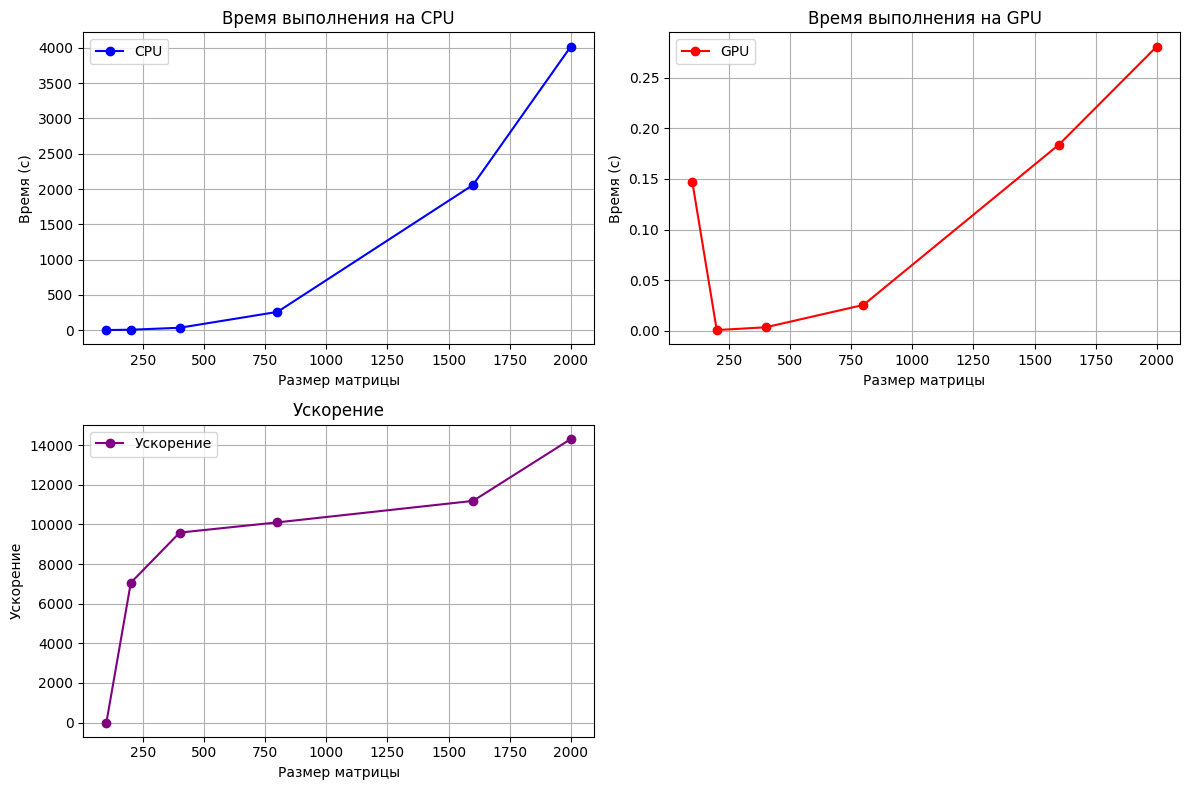

In [41]:
matrix_sizes = [100, 200, 400, 800, 1600, 2000]
results = []

for size in matrix_sizes:
    A = np.random.rand(size, size).astype(np.float32)
    B = np.random.rand(size, size).astype(np.float32)

    C_cpu, time_cpu = multiply_matrices_cpu(A, B) #На CPU
    C_gpu, time_gpu = multiply_matrices_gpu(A, B) #на GPU

    C_reference = np.dot(A, B)
    is_cpu_correct = validate_result(C_cpu, C_reference)
    is_gpu_correct = validate_result(C_gpu, C_reference)

    speedup = time_cpu / time_gpu if time_gpu > 0 else None

    results.append({
        'Размер': size,
        'Время CPU': time_cpu,
        'Время GPU': time_gpu,
        'Ускорение': speedup,
        'Корректность CPU': is_cpu_correct,
        'Корректность GPU': is_gpu_correct
    })

df = pd.DataFrame(results)
print("Результаты эксперимента:")
print(df)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(df['Размер'], df['Время CPU'], label='CPU', marker='o', color='blue')
plt.xlabel('Размер матрицы')
plt.ylabel('Время (с)')
plt.title('Время выполнения на CPU')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(df['Размер'], df['Время GPU'], label='GPU', marker='o', color='red')
plt.xlabel('Размер матрицы')
plt.ylabel('Время (с)')
plt.title('Время выполнения на GPU')
plt.legend()
plt.grid(True)

# График ускорения
plt.subplot(2, 2, 3)
plt.plot(df['Размер'], df['Ускорение'], label='Ускорение', marker='o', color='purple')
plt.xlabel('Размер матрицы')
plt.ylabel('Ускорение')
plt.title('Ускорение')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()